In [27]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


from joblib import Parallel, delayed

import pandas as pd
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sksurv.metrics import concordance_index_censored
import numpy as np
import scipy.stats
from functools import partial
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator


def mean_confidence_interval(data, confidence=0.95):
    """ Calculate mean, lower and upper bound of confidence interval """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def Dxy(e,y,x):
    """ Calculate Dxy """
    #return 2 * concordance_index_censored(e, y, x)[0] - 1
    return 2 * concordance_index(y, x, e) - 1


def bootstrap_dxy_inner(df):
    e, y, x = df.columns
    sample = df.sample(df.shape[0], replace=True)
    
    # calculate Dxy
    return Dxy(sample[e], sample[y], sample[x])


def bootstrap_dxy(df, n=5):
    """ Boostrap and calculate Dxy """
    # resample n times
    result = Parallel(n_jobs=-1)(delayed(bootstrap_dxy_inner)(df) for i in range(n))

    return result

def apply_stats_for_each_value(df, fmap, graph_filename, condition_names=None):
    """ Apply stats to each value in column """

    all_count = df.shape[0]
    
    dff = pd.DataFrame({'E':df['E'], 'Y':df['Y'], 'agg':df.apply(fmap, axis=1)}).dropna()
    selected_count = dff.shape[0]
    
    stats = dff['Y'].aggregate(['count', 'median'])
    
    dxy_bootstraped = bootstrap_dxy(dff[['E', 'Y', 'agg']])
    # confidence interval
    dxy, ci_low, ci_high =  mean_confidence_interval(dxy_bootstraped)
    
    ret = {
        'Number of patiets' : stats['count'],
        '% z całej kohorty': np.round(selected_count/all_count, 2),
        'Survival days, median' : stats['median'],
        'Survival years, median' : stats['median']/365 ,
        'Dxy': np.round(dxy, 2), 
        'Confidence interval 95% low': np.round(ci_low, 2),
        'Confidence interval 95% high': np.round(ci_high, 2),
    }
    result = pd.DataFrame(ret, index=(0,))

    groups = dff.groupby(by=['agg'])['Y'].aggregate(['count', 'median', 'min', 'max', 'std','mean'])
    
    if condition_names:
        groups.index = groups.index.map(condition_names)
    #groups.columns = ['Number of patiets', 'Survival days, median', 'min', 'max', 'std']
    
    for value in dff["agg"].unique():
        mask = (dff["agg"] == value)
        time_cell, survival_prob_cell = kaplan_meier_estimator(dff["E"][mask], dff["Y"][mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d, median = %d)" % (condition_names[value], mask.sum(), dff["Y"][mask].median()))

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("time $t$")
    plt.legend(loc="best")
    plt.savefig(graph_filename+".pdf")
    plt.show()
    plt.clf()
    return result, groups

In [28]:
DATA_PREFIX="~/secret_life_of_CVEs/data/"

In [29]:
unique_cve_info_cvss_cwe_etc_df_filename = DATA_PREFIX + 'unique_cve_info-cvss_cwe_etc.parquet'
cve_lifespan_language_df_filename = DATA_PREFIX + 'cve_lifespan_language_df'
cve_lifespan_df_filename = DATA_PREFIX + 'cve_lifespan_df'

unique_cve_info_cvss_cwe_etc_df = pd.read_parquet(unique_cve_info_cvss_cwe_etc_df_filename)

# Only main programming language is tracked (project_id, cve_id)
cve_lifespan_df = pd.read_parquet(cve_lifespan_df_filename)
commits_df = cve_lifespan_df.drop_duplicates().copy()
commits_df['cve'] = commits_df['commit_cves']
df = commits_df.merge(unique_cve_info_cvss_cwe_etc_df.drop('error', axis='columns'), on='cve')

# All programming languages are tracked (project_id, cve_id, lang_id)
cve_lifespan_language_df = pd.read_parquet(cve_lifespan_language_df_filename)
commits_df_languages = cve_lifespan_language_df.drop_duplicates()
commits_df_languages['cve'] = commits_df_languages['commit_cves']
df_languages = commits_df_languages.merge(unique_cve_info_cvss_cwe_etc_df.drop('error', axis='columns'), on='cve')

In [30]:
df['E'] = True
df['Y']=df['cve_lifespan_commiter_time'].dt.days

df_languages['E'] = True
df_languages['Y']=df['cve_lifespan_commiter_time'].dt.days

In [31]:
df.shape, df_languages.shape

((97747, 34), (287884, 34))

In [32]:
print(df['commits'].describe().to_latex( escape=False))

\begin{tabular}{lr}
\toprule
{} &       commits \\
\midrule
count &  97747.000000 \\
mean  &      5.131370 \\
std   &     29.965625 \\
min   &      1.000000 \\
25%   &      1.000000 \\
50%   &      1.000000 \\
75%   &      3.000000 \\
max   &   2349.000000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/168622293.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df['commits'].describe().to_latex( escape=False))


In [33]:
df_languages.columns

Index(['commit_cves', 'project_names', 'commits', 'used_dep_manager',
       'cve_lifespan_commiter_time', 'cve_lifespan_author_time', 'embargo_min',
       'embargo_max', 'lang_Shell', 'other_languages', 'variable', 'value',
       'programming_paradigm', 'Programming paradigm', 'compilation_class',
       'Compilation class', 'type_class', 'Type class', 'memory_model',
       'Memory model', 'extended_programming_paradigm',
       'Programming paradigm (extended)', 'cve', 'cvss', 'cwe', 'cvss-vector',
       'access.authentication', 'access.complexity', 'access.vector',
       'impact.availability', 'impact.confidentiality', 'impact.integrity',
       'E', 'Y'],
      dtype='object')

In [34]:
def compute_with_cutoff(_df, f_map_cc, condition_names_cc, graph_filename):
    condition = (_df['Y'] >= 0) & (_df['Y'] <100)
    S1, S2 = apply_stats_for_each_value(_df[condition], f_map_cc, graph_filename+"_100", condition_names_cc)
    display(S1), display(S2)
    print(S1.to_latex(), S2.to_latex())

    condition = (_df['Y'] >= 0) & (_df['Y'] <365)
    S1, S2 = apply_stats_for_each_value(_df[condition], f_map_cc, graph_filename+"_365", condition_names_cc)
    display(S1), display(S2)
    print(S1.to_latex(), S2.to_latex())

    
    condition = (_df['Y'] >= 0) & (_df['Y'] <3650)
    S1, S2 = apply_stats_for_each_value(_df[condition], f_map_cc,  graph_filename+"_3650", condition_names_cc)
    display(S1), display(S2)
    print(S1.to_latex(), S2.to_latex())


    condition = (_df['Y'] > 0)
    S1, S2 = apply_stats_for_each_value(_df[condition], f_map_cc, graph_filename+"_all", condition_names_cc )
    display(S1), display(S2)
    print(S1.to_latex(), S2.to_latex())


In [36]:
import seaborn as sns

<AxesSubplot: xlabel='commits'>

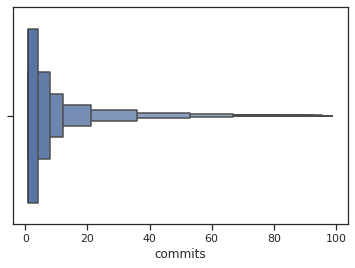

In [37]:
sns.boxenplot(data=df_languages[df_languages['commits'] < 100], x='commits', scale='exponential')

<AxesSubplot: xlabel='commits'>

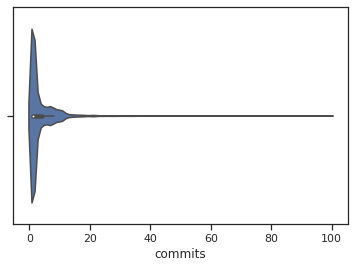

In [38]:
sns.violinplot(data=df_languages[df_languages['commits'] < 100], x='commits')

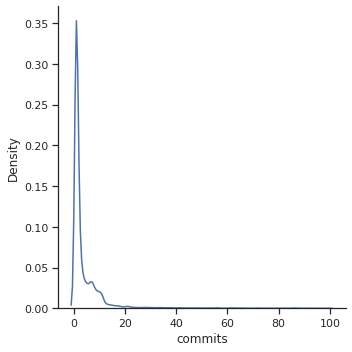

In [39]:
sns.displot(df_languages[df_languages['commits'] < 100], x='commits', kind='kde')

<AxesSubplot: xlabel='commits', ylabel='Count'>

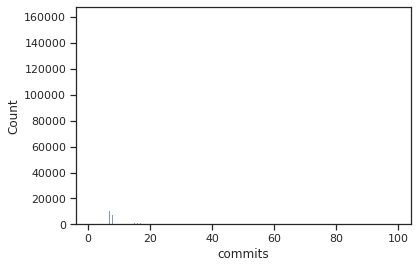

In [40]:
sns.histplot(df_languages[df_languages['commits'] < 100], x='commits')

<AxesSubplot: xlabel='commits', ylabel='Count'>

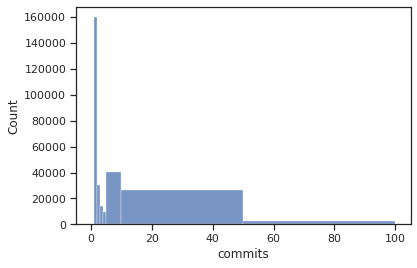

In [41]:
sns.histplot(df_languages[df_languages['commits'] >= 0], x='commits', bins=[0,1,2,3,4,5,10,50,100])

In [42]:
df_languages['commits'].describe()

count    287884.000000
mean          7.882470
std          47.519313
min           1.000000
25%           1.000000
50%           1.000000
75%           5.000000
max        2349.000000
Name: commits, dtype: float64

In [43]:
df_languages['Y'].describe()

count    97747.000000
mean       569.044810
std       1065.012619
min          0.000000
25%         17.000000
50%        142.000000
75%        565.000000
max       8019.000000
Name: Y, dtype: float64

# Outliers projects

In [44]:
df_languages[df_languages['commits']>= 50]['project_names'].unique()

array(['NetBSD_src', 'freebsd_freebsd', 'joyent_pkgsrc-legacy',
       'python_cpython', 'gitlab.com_quicla_platform/cts',
       'openssl_openssl', 'pfsense_FreeBSD-ports',
       'git.openembedded.org_openembedded-core-contrib',
       'libressl-portable_openbsd', 'Jackeagle_kernel_msm-3.18',
       'MIPS_gcc', 'illacceptanything_illacceptanything',
       'gitlab.freedesktop.org_mesa_mesa', 'samba-team_samba',
       'NixOS_nixpkgs', 'patchew-project_next-importer-push',
       'asterisk_asterisk', 'glennrp_libpng', 'delphix_grub2',
       'android.googlesource.com_platform_libcore',
       'daedroza_aosp_development_sony8960_n', 'iqer_nginx',
       'ZIDAN44_linux-stable', 'spiderworthy_linux',
       'apple_llvm-project-v5-split', 'jayanta525_openwrt-nanopi-r4s',
       'HazouPH_android_kernel_motorola_smi', 'opencontainers_runc',
       'oss-qm_perl5', 'codeaurora-unofficial_platform-packages-apps-Mms',
       'bloomberg_chromium.bb',
       'codeaurora-unofficial_platform-framew

In [45]:
(df.groupby(by=['project_names', 'commit_cves']).count()['commits'] > 1).sum()

0

In [46]:
(df_languages.groupby(by=['project_names', 'commit_cves']).count()['commits'] > 1).sum()

49229

In [47]:
df

,commits,commit_cves,project_names,used_dep_manager,cve_lifespan_commiter_time,cve_lifespan_author_time,embargo_min,embargo_max,lang_Shell,other_languages,...,cwe,cvss-vector,access.authentication,access.complexity,access.vector,impact.availability,impact.confidentiality,impact.integrity,E,Y
0,1,CVE-2011-1079,0-artnoc_sm-a307fn,0,3497 days 01:37:41,2978 days 21:29:59,False,False,0.0,0.0,...,CWE-20,AV:L/AC:M/Au:N/C:P/I:N/A:C,NONE,MEDIUM,LOCAL,COMPLETE,PARTIAL,NONE,True,3497
1,2,CVE-2011-1079,150balbes_Amlogic_s905-kernel,0,3069 days 09:26:00,2978 days 21:29:59,False,False,0.0,0.0,...,CWE-20,AV:L/AC:M/Au:N/C:P/I:N/A:C,NONE,MEDIUM,LOCAL,COMPLETE,PARTIAL,NONE,True,3069
2,1,CVE-2011-1079,84506232_sm-g9750_graingripper,0,3098 days 12:25:02,2978 days 21:29:59,False,False,0.0,0.0,...,CWE-20,AV:L/AC:M/Au:N/C:P/I:N/A:C,NONE,MEDIUM,LOCAL,COMPLETE,PARTIAL,NONE,True,3098
3,1,CVE-2011-1079,Ante0_CarbonKernel,0,2958 days 16:10:21,2978 days 21:29:59,False,False,0.0,0.0,...,CWE-20,AV:L/AC:M/Au:N/C:P/I:N/A:C,NONE,MEDIUM,LOCAL,COMPLETE,PARTIAL,NONE,True,2958
4,2,CVE-2011-1079,Backup-Gits_Eureka-Kernel-Exynos7885-Q-R,0,3751 days 10:01:38,2978 days 21:29:59,False,False,0.0,0.0,...,CWE-20,AV:L/AC:M/Au:N/C:P/I:N/A:C,NONE,MEDIUM,LOCAL,COMPLETE,PARTIAL,NONE,True,3751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97742,1,CVE-2020-24582,zulip_zulip-desktop,1,0 days 00:00:00,0 days 00:00:00,True,True,0.0,0.0,...,CWE-79,AV:N/AC:M/Au:N/C:N/I:P/A:N,NONE,MEDIUM,NETWORK,NONE,NONE,PARTIAL,True,0
97743,2,CVE-2013-1441,zuphilip_svn.exactcode.de-exact-image,0,47 days 19:13:18,47 days 19:13:18,False,False,0.0,0.0,...,CWE-20,AV:N/AC:M/Au:N/C:N/I:N/A:P,NONE,MEDIUM,NETWORK,PARTIAL,NONE,NONE,True,47
97744,1,CVE-2018-1000854,zweilosec_python-pearls,0,603 days 22:33:48,603 days 22:33:48,False,False,0.0,0.0,...,CWE-74,AV:N/AC:L/Au:N/C:P/I:P/A:P,NONE,LOW,NETWORK,PARTIAL,PARTIAL,PARTIAL,True,603
97745,3,CVE-2020-23934,zyeinn_CVE-2020-23934,0,347 days 19:13:06,347 days 19:13:06,False,False,0.0,0.0,...,CWE-78,AV:N/AC:L/Au:S/C:C/I:C/A:C,SINGLE,LOW,NETWORK,COMPLETE,COMPLETE,COMPLETE,True,347


# Selecting cut-off

In [48]:
df['Y'].median()

142.0

# Rozkłady liczba commitów - czas

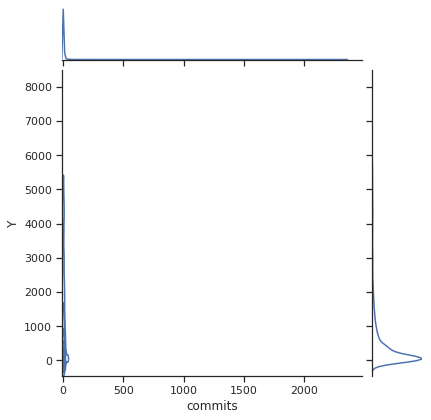

In [49]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df_languages,
    x="commits", y="Y",
    kind="kde",
)

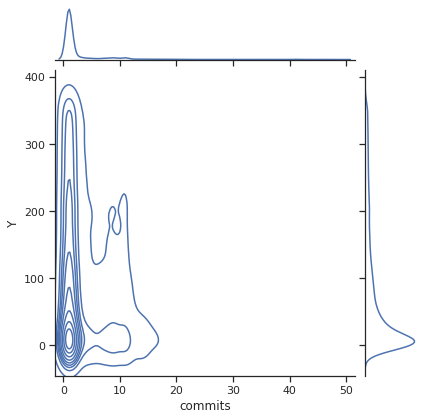

In [50]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df_languages[(df_languages['Y']<365)& (df_languages['commits']<50)],
    x="commits", y="Y",
    kind="kde",
)

In [52]:
df['most_common_language'].unique()

array(['lang_C', 'lang_Python', 'lang_Clojure', 'lang_PLSQL', 'lang_Ruby',
       'lang_Assembly', 'lang_C++', 'lang_Go', 'lang_PHP', 'lang_C#',
       'lang_PowerShell', 'lang_JavaScript', 'lang_Lua', 'lang_Java',
       'lang_Scheme', 'lang_Objective-C', 'lang_Scala', 'lang_Perl',
       'lang_VBScript', 'lang_Groovy', 'lang_OCaml', 'lang_TypeScript',
       'lang_Erlang', 'lang_R', 'lang_Elixir', 'lang_Prolog', 'lang_Tcl',
       'lang_Ada', 'lang_Emacs Lisp', 'lang_Dart', 'lang_Kotlin',
       'lang_Forth', 'lang_Smalltalk', 'lang_Crystal', 'lang_Haskell',
       'lang_Swift', 'lang_Common Lisp', 'lang_Solidity', 'lang_Io'],
      dtype=object)

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:1185: UserWarning: No contour levels were found within the data range.
  cset = contour_func(
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1877: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` 

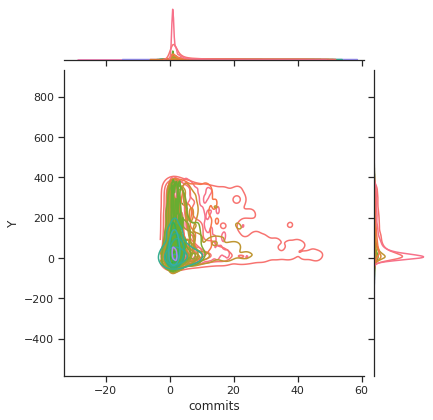

In [53]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df[(df['Y']<365)& (df['commits']<50)],
    x="commits", y="Y", hue='most_common_language',
    kind="kde", legend=False
)

In [54]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df[(df['Y']<365)& (df['commits']<50)&(df['most_common_language'].isin(tiobe_top_5))],
    x="commits", y="Y", hue='most_common_language',
    kind="kde", legend=False
)

NameError: name 'tiobe_top_5' is not defined

In [55]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=df[(df['Y']<365)& (df['commits']<50)&(df['most_common_language'].isin(tiobe_top_5[:3]))],
    x="commits", y="Y", hue='most_common_language',
    kind="kde", legend=True
)

NameError: name 'tiobe_top_5' is not defined

In [56]:
import seaborn as sns

sns.set_theme(style="darkgrid")

sns.displot(
    
    data=df_languages[(df_languages['Y']<365)& (df_languages['commits']<50)&(df_languages['most_common_language'].isin(tiobe_top_5[:3]))],
    x="commits", y="Y", col='most_common_language',
    kind="kde", legend=True
)

KeyError: 'most_common_language'

# analiza przeżycia bez czynników

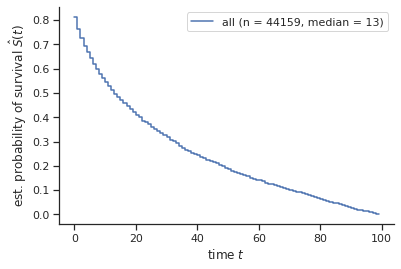

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44159.0,1.0,13.0,0.035616,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
all,44159,13.0,0.0,99.0,27.337155,24.425032


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44159.0 &                1.0 &                   13.0 &                0.035616 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &        std &       mean \\
agg &        &         &      &       &            &            \\
\midrule
all &  44159 &    13.0 &  0.0 &  99.0 &  27.337155 &  24.425032 \\
\bottomrule
\end{tabular}



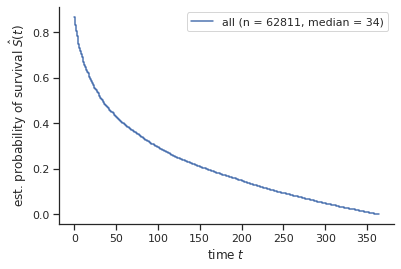

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
all,62811,34.0,0.0,364.0,97.023413,79.430386


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg &        &         &      &        &            &            \\
\midrule
all &  62811 &    34.0 &  0.0 &  364.0 &  97.023413 &  79.430386 \\
\bottomrule
\end{tabular}



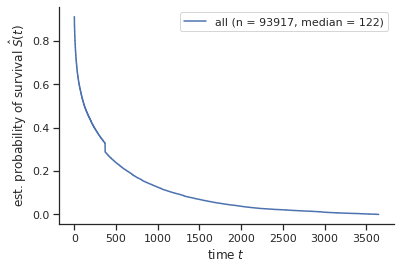

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
all,93917,122.0,0.0,3649.0,621.955935,395.679728


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &     max &         std &        mean \\
agg &        &         &      &         &             &             \\
\midrule
all &  93917 &   122.0 &  0.0 &  3649.0 &  621.955935 &  395.679728 \\
\bottomrule
\end{tabular}



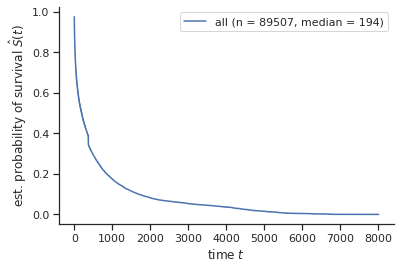

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
all,89507,194.0,1.0,8019.0,1098.233735,621.430983


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &     max &          std &        mean \\
agg &        &         &      &         &              &             \\
\midrule
all &  89507 &   194.0 &  1.0 &  8019.0 &  1098.233735 &  621.430983 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [60]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map_pp(x):
    return 1
condition_names_pp = {1 : 'all'}

compute_with_cutoff(df_languages, f_map_pp, condition_names_pp, "survival_analysis")


# Languages spec

In [61]:
df_languages.groupby(by='variable').agg({'value':'sum'})

,value
variable,
lang_Ada,79174.0
lang_Assembly,1063650.0
lang_C,56970880.0
lang_C#,71384.0
lang_C++,28481025.0
lang_Clojure,2517523.0
lang_Common Lisp,134638.0
lang_Crystal,248.0
lang_Dart,113.0


,value
variable,
lang_Ada,46273.0
lang_Assembly,236319.0
lang_C,13351116.0
lang_C#,11377.0
lang_C++,9572269.0
lang_Clojure,498919.0
lang_Common Lisp,65056.0
lang_Crystal,3.0
lang_Dart,1.0


['C', 'C++', 'Java', 'Python', 'other']
[13351116.  9572269.    63353.   744049.  7031093.]


([<matplotlib.patches.Wedge at 0x7fb93d79f370>,
 [Text(-1.174308729664161, 0.24697977130636556, 'C'),
  Text(0.6404536488459944, -1.0148000412297251, 'C++'),
  Text(1.199661180671519, -0.028514059511357995, 'Java'),
  Text(1.197933677561237, 0.07039108014947985, 'Python'),
  Text(0.7895080218587057, 0.9037018775131287, 'other')],
 [Text(-0.6850134256374272, 0.14407153326204655, '43.4%'),
  Text(0.3735979618268301, -0.5919666907173395, '31.1%'),
  Text(0.6998023553917193, -0.016633201381625495, '0.2%'),
  Text(0.6987946452440548, 0.04106146342052991, '2.4%'),
  Text(0.46054634608424494, 0.527159428549325, '22.9%')])

(-1.2077355239193257,
 1.2097117745683414,
 -1.1925601893122388,
 1.1833022364168087)

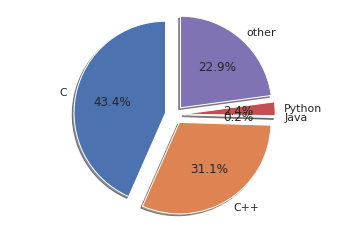

In [62]:
sel = df_languages['Y']<=365
tiobe_agg = df_languages[sel].groupby(by='variable').agg({'value':'sum'})
tiobe_agg

tiobe_top_5 = ['lang_Python', 'lang_C', 'lang_C++', 'lang_Java']

ret = tiobe_agg[tiobe_agg.index.isin(tiobe_top_5)].copy()

ret.loc['_other']=tiobe_agg[~tiobe_agg.index.isin(tiobe_top_5)].sum()

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ret.index.map(lambda x: x.split("_")[1]).to_list()
print(labels)
sizes = ret.to_numpy().flatten()
explode = (0.1,) * len(sizes) # only "explode" the 2nd slice (i.e. 'Hogs')

print(sizes)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig("languages_sum_files.pdf")
plt.show()


['C', 'C++', 'Java', 'Python', 'other']
[ 5543  4080  2149  5391 45703]


([<matplotlib.patches.Wedge at 0x7fb93d6702b0>,
 [Text(-0.32816487467163036, 1.1542563905093848, 'C'),
  Text(-0.8248669698754485, 0.871547177155945, 'C++'),
  Text(-1.0521614262898302, 0.5770236849798718, 'Java'),
  Text(-1.1906622947981207, 0.14940983818367945, 'Python'),
  Text(0.9075953381821436, -0.7850291090845235, 'other')],
 [Text(-0.19142951022511767, 0.673316227797141, '8.8%'),
  Text(-0.48117239909401155, 0.5084025200076345, '6.5%'),
  Text(-0.6137608320024008, 0.33659714957159187, '3.4%'),
  Text(-0.6945530052989037, 0.08715573894047966, '8.6%'),
  Text(0.5294306139395837, -0.45793364696597205, '72.7%')])

(-1.2079644608200026, 1.1843738159606, -1.1734949627737925, 1.2042681751765554)

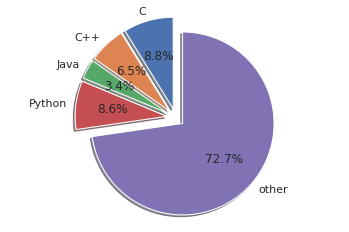

In [63]:
sel = df_languages['Y']<=365
tiobe_agg = df_languages[sel].groupby(by='variable').agg({'value':'count'})
tiobe_top_5 = ['lang_Python', 'lang_C', 'lang_C++', 'lang_Java']

ret = tiobe_agg[tiobe_agg.index.isin(tiobe_top_5)].copy()

ret.loc['_other']=tiobe_agg[~tiobe_agg.index.isin(tiobe_top_5)].sum()

import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ret.index.map(lambda x: x.split("_")[1]).to_list()
print(labels)
sizes = ret.to_numpy().flatten()
explode = (0.1,) * len(sizes) # only "explode" the 2nd slice (i.e. 'Hogs')

print(sizes)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig("languages_count_commits.pdf")
plt.show()


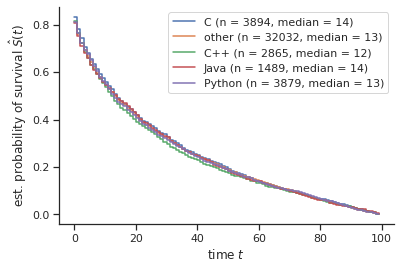

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44159.0,1.0,13.0,0.035616,-0.0,-0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
Python,3879,13.0,0.0,99.0,27.321409,24.304460
C,3894,14.0,0.0,99.0,27.369238,24.959938
C++,2865,12.0,0.0,99.0,26.973708,23.486213
Java,1489,14.0,0.0,99.0,27.291358,24.366017
other,32032,13.0,0.0,99.0,27.369117,24.461320


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44159.0 &                1.0 &                   13.0 &                0.035616 & -0.0 &                         -0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &        std &       mean \\
agg    &        &         &      &       &            &            \\
\midrule
Python &   3879 &    13.0 &  0.0 &  99.0 &  27.321409 &  24.304460 \\
C      &   3894 &    14.0 &  0.0 &  99.0 &  27.369238 &  24.959938 \\
C++    &   2865 &    12.0 &  0.0 &  99.0 &  26.973708 &  23.486213 \\
Java   &   1489 &    14.0 &  0.0 &  99.0 &  27.291358 &  24.366017 \\
other  &  32032 &    13.0 &  0.0 &  99.0 &  27.369117 &  24.461320 \\
\bottomrule
\end{tabular}



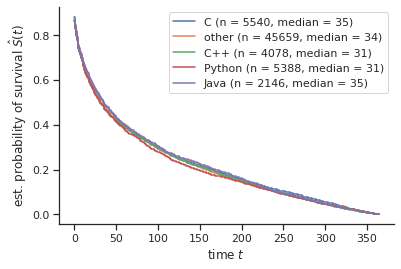

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
Python,5388,31.0,0.0,364.0,95.785913,76.419451
C,5540,35.0,0.0,364.0,98.980335,81.327256
C++,4078,31.0,0.0,364.0,96.716424,78.689063
Java,2146,35.0,0.0,364.0,98.047903,81.543802
other,45659,34.0,0.0,364.0,96.902709,79.522416


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg    &        &         &      &        &            &            \\
\midrule
Python &   5388 &    31.0 &  0.0 &  364.0 &  95.785913 &  76.419451 \\
C      &   5540 &    35.0 &  0.0 &  364.0 &  98.980335 &  81.327256 \\
C++    &   4078 &    31.0 &  0.0 &  364.0 &  96.716424 &  78.689063 \\
Java   &   2146 &    35.0 &  0.0 &  364.0 &  98.047903 &  81.543802 \\
other  &  45659 &    34.0 &  0.0 &  364.0 &  96.902709 &  79.522416 \\
\bottomrule
\end{tabular}



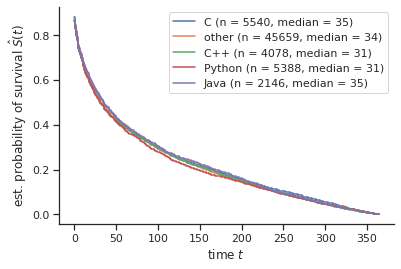

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,0.0,-0.0,0.01


,count,median,min,max,std,mean
agg,,,,,,
Python,5388,31.0,0.0,364.0,95.785913,76.419451
C,5540,35.0,0.0,364.0,98.980335,81.327256
C++,4078,31.0,0.0,364.0,96.716424,78.689063
Java,2146,35.0,0.0,364.0,98.047903,81.543802
other,45659,34.0,0.0,364.0,96.902709,79.522416


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 &  0.0 &                         -0.0 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg    &        &         &      &        &            &            \\
\midrule
Python &   5388 &    31.0 &  0.0 &  364.0 &  95.785913 &  76.419451 \\
C      &   5540 &    35.0 &  0.0 &  364.0 &  98.980335 &  81.327256 \\
C++    &   4078 &    31.0 &  0.0 &  364.0 &  96.716424 &  78.689063 \\
Java   &   2146 &    35.0 &  0.0 &  364.0 &  98.047903 &  81.543802 \\
other  &  45659 &    34.0 &  0.0 &  364.0 &  96.902709 &  79.522416 \\
\bottomrule
\end{tabular}



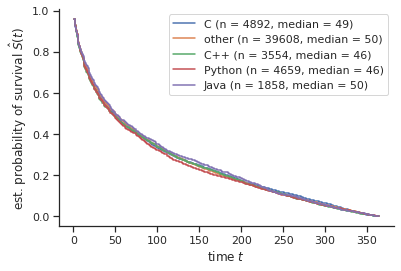

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,54571.0,1.0,49.0,0.134247,0.01,0.0,0.01


,count,median,min,max,std,mean
agg,,,,,,
Python,4659,46.0,1.0,364.0,97.743926,88.376905
C,4892,49.0,1.0,364.0,100.512386,92.099959
C++,3554,46.0,1.0,364.0,98.416333,90.290940
Java,1858,50.0,1.0,364.0,99.565184,94.183531
other,39608,50.0,1.0,364.0,98.544396,91.671228


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            54571.0 &                1.0 &                   49.0 &                0.134247 &  0.01 &                          0.0 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &         std &       mean \\
agg    &        &         &      &        &             &            \\
\midrule
Python &   4659 &    46.0 &  1.0 &  364.0 &   97.743926 &  88.376905 \\
C      &   4892 &    49.0 &  1.0 &  364.0 &  100.512386 &  92.099959 \\
C++    &   3554 &    46.0 &  1.0 &  364.0 &   98.416333 &  90.290940 \\
Java   &   1858 &    50.0 &  1.0 &  364.0 &   99.565184 &  94.183531 \\
other  &  39608 &    50.0 &  1.0 &  364.0 &   98.544396 &  91.671228 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [64]:
tiobe_top_5 = {'lang_Python':1, 'lang_C':2, 'lang_C++':3, 'lang_Java':4}


def f_map_pp(x):
    a = str(x['variable'])
    if a in tiobe_top_5:
        return tiobe_top_5[a]
    else:
        return 5

condition_names_pp = {1 : 'Python', 2: 'C', 3:'C++', 4: 'Java', 5:'other'}

compute_with_cutoff(df_languages[df_languages['Y']<365], f_map_pp, condition_names_pp, "top_5_survival_analysis")

# Popularity

In [65]:
tiobe = pd.read_csv("../data/tiobe.csv", index_col=False)
df_languages['lang'] = df_languages['variable'].map(lambda x: x.split("_")[1])
df_languages['lang'][df_languages['lang'] == 'PLSQL'] = 'SQL'

df_tiobe = df_languages.merge(tiobe[['language', 'dec2022']], how="left", left_on="lang", right_on="language")
df_tiobe['dec2022']

/tmp/ipykernel_3826835/3931425155.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_languages['lang'][df_languages['lang'] == 'PLSQL'] = 'SQL'


0         30.0
1          NaN
2          2.0
3          2.0
4          2.0
          ... 
287879    41.0
287880    41.0
287881    41.0
287882    51.0
287883    51.0
Name: dec2022, Length: 287884, dtype: float64

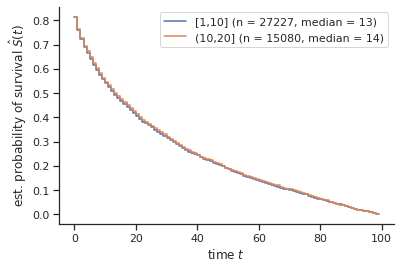

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,42307.0,0.96,13.0,0.035616,0.01,0.0,0.01


,count,median,min,max,std,mean
agg,,,,,,
"[1,10]",27227,13.0,0.0,99.0,27.287074,24.27616
"(10,20]",15080,14.0,0.0,99.0,27.431926,24.67374


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            42307.0 &               0.96 &                   13.0 &                0.035616 &  0.01 &                          0.0 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &        std &      mean \\
agg     &        &         &      &       &            &           \\
\midrule
[1,10]  &  27227 &    13.0 &  0.0 &  99.0 &  27.287074 &  24.27616 \\
(10,20] &  15080 &    14.0 &  0.0 &  99.0 &  27.431926 &  24.67374 \\
\bottomrule
\end{tabular}



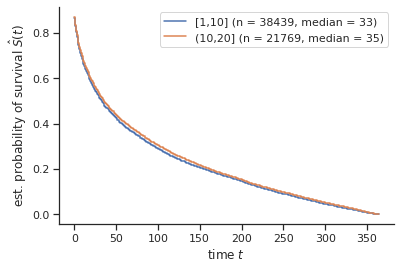

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,60208.0,0.96,34.0,0.093151,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
"[1,10]",38439,33.0,0.0,364.0,96.225922,78.211686
"(10,20]",21769,35.0,0.0,364.0,98.357342,81.698884


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            60208.0 &               0.96 &                   34.0 &                0.093151 &  0.01 &                         0.01 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg     &        &         &      &        &            &            \\
\midrule
[1,10]  &  38439 &    33.0 &  0.0 &  364.0 &  96.225922 &  78.211686 \\
(10,20] &  21769 &    35.0 &  0.0 &  364.0 &  98.357342 &  81.698884 \\
\bottomrule
\end{tabular}



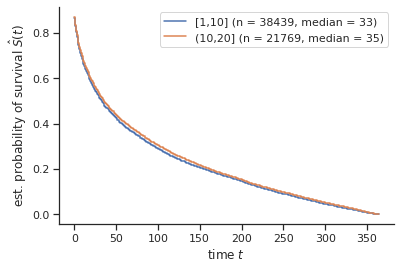

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,60208.0,0.96,34.0,0.093151,0.01,0.01,0.01


,count,median,min,max,std,mean
agg,,,,,,
"[1,10]",38439,33.0,0.0,364.0,96.225922,78.211686
"(10,20]",21769,35.0,0.0,364.0,98.357342,81.698884


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            60208.0 &               0.96 &                   34.0 &                0.093151 &  0.01 &                         0.01 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg     &        &         &      &        &            &            \\
\midrule
[1,10]  &  38439 &    33.0 &  0.0 &  364.0 &  96.225922 &  78.211686 \\
(10,20] &  21769 &    35.0 &  0.0 &  364.0 &  98.357342 &  81.698884 \\
\bottomrule
\end{tabular}



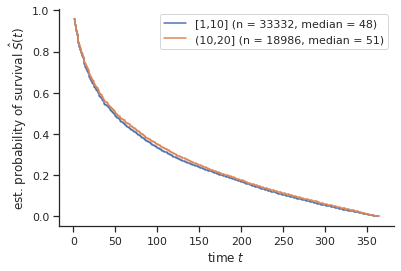

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,52318.0,0.96,49.0,0.134247,0.01,0.0,0.01


,count,median,min,max,std,mean
agg,,,,,,
"[1,10]",33332,48.0,1.0,364.0,97.965806,90.194978
"(10,20]",18986,51.0,1.0,364.0,99.852061,93.674444


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            52318.0 &               0.96 &                   49.0 &                0.134247 &  0.01 &                          0.0 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg     &        &         &      &        &            &            \\
\midrule
[1,10]  &  33332 &    48.0 &  1.0 &  364.0 &  97.965806 &  90.194978 \\
(10,20] &  18986 &    51.0 &  1.0 &  364.0 &  99.852061 &  93.674444 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [66]:
def f_map_cc(x):
    try:
        a = int(x['dec2022'])
        if a <= 20:
            return 1
        elif a > 20:
            return 2
        else:
            return 3
    except:
        return None

condition_names_cc = {1 : '[1,10]', 2: '(10,20]', 3:"(20,100)"}
compute_with_cutoff(df_tiobe[df_tiobe['Y']<365], f_map_cc, condition_names_cc, "popularity_survival_analysis")

In [67]:
tiobe_top_5 = {'lang_Python':1, 'lang_C':2, 'lang_C++':3, 'lang_Java':4}

df_languages['top4'] = df_languages['variable'].map(lambda x: x if x in tiobe_top_5 else 'lang_other')

In [68]:
agg_lang_top = df_languages.groupby(by=['project_names', 'commit_cves']).agg({'top4':'sum'})
agg_lang_top['top'] = agg_lang_top['top4'].map(lambda x: tuple(set(x.split("lang_")[1:])))

In [69]:
agg_lang_top['number_of_languages'] = agg_lang_top['top4'].map(lambda x: len(x.split("lang_")[1:]))

In [70]:
Z = agg_lang_top.groupby(by='top').agg('count')

In [71]:
X = agg_lang_top.groupby('number_of_languages').agg('count')
X.loc[:1]['top4'].sum()
X.loc[2:]['top4'].sum()

48518

49229

In [72]:
X

,top4,top
number_of_languages,,
1,48518,48518
2,22287,22287
3,11433,11433
4,2638,2638
5,2073,2073
6,1586,1586
7,1178,1178
8,1193,1193
9,833,833


In [73]:
from collections import defaultdict

rdict = defaultdict(lambda: defaultdict(int))

for r in Z.itertuples():
    for l1 in r[0]:
        for l2 in r[0]:
            rdict[l1][l2] += r[1]
            
            
for l1 in rdict:
    for l2 in rdict[l1]:
        print(f"2009, {l1}, {l2}, {rdict[l1][l2]}, {rdict[l1][l2]}")


2009, C, C, 43532, 43532
2009, C, C++, 23597, 23597
2009, C, Java, 5379, 5379
2009, C, Python, 11780, 11780
2009, C, other, 24378, 24378
2009, C++, C++, 27786, 27786
2009, C++, C, 23597, 23597
2009, C++, Java, 5387, 5387
2009, C++, Python, 11763, 11763
2009, C++, other, 25722, 25722
2009, Java, C++, 5387, 5387
2009, Java, Java, 11549, 11549
2009, Java, C, 5379, 5379
2009, Java, Python, 5305, 5305
2009, Java, other, 5643, 5643
2009, Python, C++, 11763, 11763
2009, Python, Java, 5305, 5305
2009, Python, Python, 38953, 38953
2009, Python, C, 11780, 11780
2009, Python, other, 32827, 32827
2009, other, C++, 25722, 25722
2009, other, other, 64984, 64984
2009, other, C, 24378, 24378
2009, other, Java, 5643, 5643
2009, other, Python, 32827, 32827


In [74]:
rdict

defaultdict(<function __main__.<lambda>()>,
            {'C': defaultdict(int,
                         {'C': 43532,
                          'C++': 23597,
                          'Java': 5379,
                          'Python': 11780,
                          'other': 24378}),
             'C++': defaultdict(int,
                         {'C++': 27786,
                          'C': 23597,
                          'Java': 5387,
                          'Python': 11763,
                          'other': 25722}),
             'Java': defaultdict(int,
                         {'C++': 5387,
                          'Java': 11549,
                          'C': 5379,
                          'Python': 5305,
                          'other': 5643}),
             'Python': defaultdict(int,
                         {'C++': 11763,
                          'Java': 5305,
                          'Python': 38953,
                          'C': 11780,
                          'other'

In [75]:
from chord import Chord



In [76]:
matrix = pd.DataFrame(rdict).values.tolist()
names = pd.DataFrame(rdict).columns.tolist()

fname="~/secret_life_of_CVEs/notebooks/chord.html"

#Chord(matrix,names).to_html(fname)
matrix



[[43532, 23597, 5379, 11780, 24378],
 [23597, 27786, 5387, 11763, 25722],
 [5379, 5387, 11549, 5305, 5643],
 [11780, 11763, 5305, 38953, 32827],
 [24378, 25722, 5643, 32827, 64984]]

In [ ]:
%%html
<iframe src="chord.html" width="800" height="600" title="Chord diagram with the chord library" style="border:none"></iframe>


# Compilation class, Type class and Memory model for All languages
Do not use - the one with most common language are better

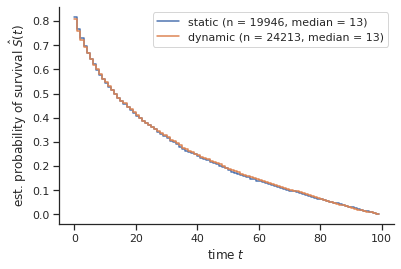

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44159.0,1.0,13.0,0.035616,-0.0,-0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
static,19946,13.0,0.0,99.0,27.216640,24.294796
dynamic,24213,13.0,0.0,99.0,27.436132,24.532317


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44159.0 &                1.0 &                   13.0 &                0.035616 & -0.0 &                         -0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &        std &       mean \\
agg     &        &         &      &       &            &            \\
\midrule
static  &  19946 &    13.0 &  0.0 &  99.0 &  27.216640 &  24.294796 \\
dynamic &  24213 &    13.0 &  0.0 &  99.0 &  27.436132 &  24.532317 \\
\bottomrule
\end{tabular}



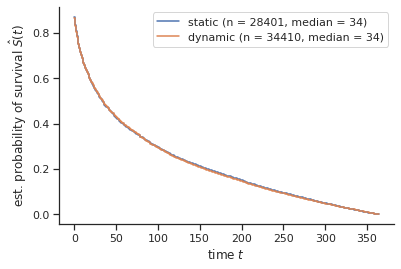

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,0.0,-0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
static,28401,34.0,0.0,364.0,97.410880,79.719763
dynamic,34410,34.0,0.0,364.0,96.703204,79.191543


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 &  0.0 &                         -0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg     &        &         &      &        &            &            \\
\midrule
static  &  28401 &    34.0 &  0.0 &  364.0 &  97.410880 &  79.719763 \\
dynamic &  34410 &    34.0 &  0.0 &  364.0 &  96.703204 &  79.191543 \\
\bottomrule
\end{tabular}



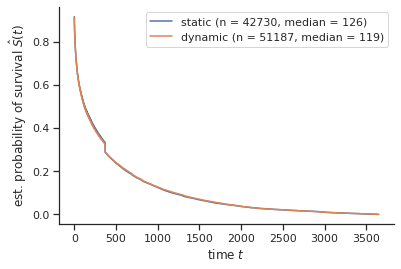

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,-0.0,-0.0,-0.0


,count,median,min,max,std,mean
agg,,,,,,
static,42730,126.0,0.0,3649.0,619.154879,395.051814
dynamic,51187,119.0,0.0,3645.0,624.290143,396.203899


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 & -0.0 &                         -0.0 &                          -0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &     max &         std &        mean \\
agg     &        &         &      &         &             &             \\
\midrule
static  &  42730 &   126.0 &  0.0 &  3649.0 &  619.154879 &  395.051814 \\
dynamic &  51187 &   119.0 &  0.0 &  3645.0 &  624.290143 &  396.203899 \\
\bottomrule
\end{tabular}



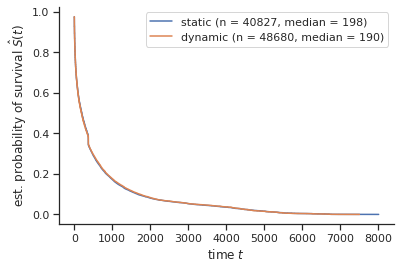

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,-0.0,-0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
static,40827,198.0,1.0,8019.0,1095.237534,617.980968
dynamic,48680,190.0,1.0,7512.0,1100.743211,624.324445


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 & -0.0 &                         -0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &     max &          std &        mean \\
agg     &        &         &      &         &              &             \\
\midrule
static  &  40827 &   198.0 &  1.0 &  8019.0 &  1095.237534 &  617.980968 \\
dynamic &  48680 &   190.0 &  1.0 &  7512.0 &  1100.743211 &  624.324445 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [77]:
# to remove
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map(x):
    a = int(x['compilation_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'static', 2: 'dynamic', 0: 'other'}

compute_with_cutoff(df_languages, f_map, condition_names, "all_language_compilation_class_survival_analysis")

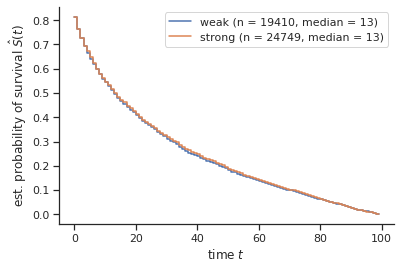

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44159.0,1.0,13.0,0.035616,-0.0,-0.01,0.0


,count,median,min,max,std,mean
agg,,,,,,
strong,24749,13.0,0.0,99.0,27.434016,24.597721
weak,19410,13.0,0.0,99.0,27.212269,24.204843


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44159.0 &                1.0 &                   13.0 &                0.035616 & -0.0 &                        -0.01 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &        std &       mean \\
agg    &        &         &      &       &            &            \\
\midrule
strong &  24749 &    13.0 &  0.0 &  99.0 &  27.434016 &  24.597721 \\
weak   &  19410 &    13.0 &  0.0 &  99.0 &  27.212269 &  24.204843 \\
\bottomrule
\end{tabular}



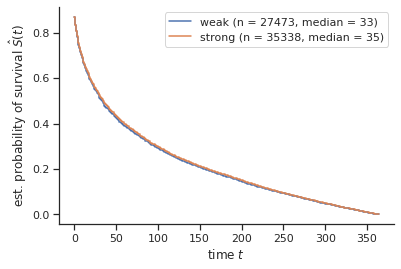

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,-0.01,-0.01,-0.0


,count,median,min,max,std,mean
agg,,,,,,
strong,35338,35.0,0.0,364.0,97.344733,80.145170
weak,27473,33.0,0.0,364.0,96.602527,78.510974


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 & -0.01 &                        -0.01 &                          -0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg    &        &         &      &        &            &            \\
\midrule
strong &  35338 &    35.0 &  0.0 &  364.0 &  97.344733 &  80.145170 \\
weak   &  27473 &    33.0 &  0.0 &  364.0 &  96.602527 &  78.510974 \\
\bottomrule
\end{tabular}



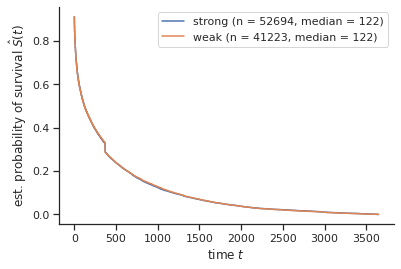

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,-0.0,-0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
strong,52694,122.0,0.0,3646.0,622.355080,394.842582
weak,41223,122.0,0.0,3649.0,621.451253,396.749824


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 & -0.0 &                         -0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &     max &         std &        mean \\
agg    &        &         &      &         &             &             \\
\midrule
strong &  52694 &   122.0 &  0.0 &  3646.0 &  622.355080 &  394.842582 \\
weak   &  41223 &   122.0 &  0.0 &  3649.0 &  621.451253 &  396.749824 \\
\bottomrule
\end{tabular}



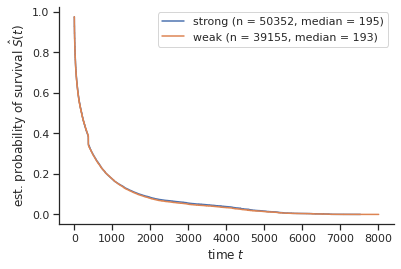

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,-0.0,-0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
strong,50352,195.0,1.0,7538.0,1116.658254,629.812639
weak,39155,193.0,1.0,8019.0,1073.994044,610.652458


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 & -0.0 &                         -0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &     max &          std &        mean \\
agg    &        &         &      &         &              &             \\
\midrule
strong &  50352 &   195.0 &  1.0 &  7538.0 &  1116.658254 &  629.812639 \\
weak   &  39155 &   193.0 &  1.0 &  8019.0 &  1073.994044 &  610.652458 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [78]:
# to remove
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map(x):
    a = int(x['type_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'strong', 2: 'weak', 0: 'other'}

compute_with_cutoff(df_languages, f_map, condition_names, "all_language_type_class_survival_analysis")

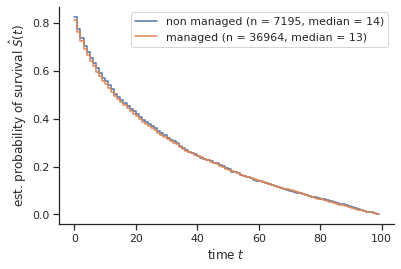

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44159.0,1.0,13.0,0.035616,0.0,0.0,0.01


,count,median,min,max,std,mean
agg,,,,,,
managed,36964,13.0,0.0,99.0,27.340612,24.362434
non managed,7195,14.0,0.0,99.0,27.319028,24.746630


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44159.0 &                1.0 &                   13.0 &                0.035616 &  0.0 &                          0.0 &                          0.01 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &        std &       mean \\
agg         &        &         &      &       &            &            \\
\midrule
managed     &  36964 &    13.0 &  0.0 &  99.0 &  27.340612 &  24.362434 \\
non managed &   7195 &    14.0 &  0.0 &  99.0 &  27.319028 &  24.746630 \\
\bottomrule
\end{tabular}



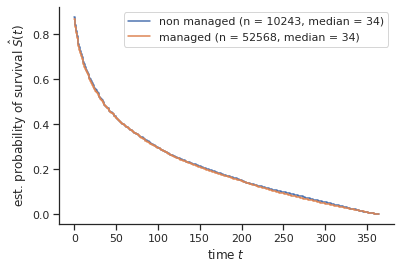

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,0.0,-0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
managed,52568,34.0,0.0,364.0,96.803644,79.224376
non managed,10243,34.0,0.0,364.0,98.141510,80.487650


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 &  0.0 &                         -0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &    max &        std &       mean \\
agg         &        &         &      &        &            &            \\
\midrule
managed     &  52568 &    34.0 &  0.0 &  364.0 &  96.803644 &  79.224376 \\
non managed &  10243 &    34.0 &  0.0 &  364.0 &  98.141510 &  80.487650 \\
\bottomrule
\end{tabular}



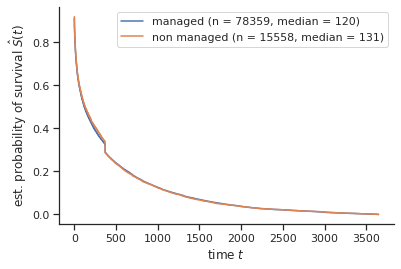

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,0.0,0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
managed,78359,120.0,0.0,3646.0,622.593172,395.445437
non managed,15558,131.0,0.0,3649.0,618.755047,396.859751


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 &  0.0 &                          0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &     max &         std &        mean \\
agg         &        &         &      &         &             &             \\
\midrule
managed     &  78359 &   120.0 &  0.0 &  3646.0 &  622.593172 &  395.445437 \\
non managed &  15558 &   131.0 &  0.0 &  3649.0 &  618.755047 &  396.859751 \\
\bottomrule
\end{tabular}



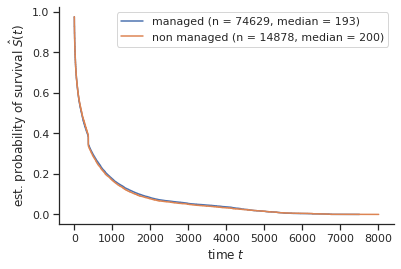

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,-0.0,-0.0,0.0


,count,median,min,max,std,mean
agg,,,,,,
managed,74629,193.0,1.0,7512.0,1102.989406,624.949926
non managed,14878,200.0,1.0,8019.0,1073.923760,603.779742


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 & -0.0 &                         -0.0 &                           0.0 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &     max &          std &        mean \\
agg         &        &         &      &         &              &             \\
\midrule
managed     &  74629 &   193.0 &  1.0 &  7512.0 &  1102.989406 &  624.949926 \\
non managed &  14878 &   200.0 &  1.0 &  8019.0 &  1073.923760 &  603.779742 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [79]:
# to remove
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

def f_map(x):
    a = int(x['memory_model'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'managed', 2: 'non managed', 0: 'other'}
compute_with_cutoff(df_languages, f_map, condition_names, "all_language_memory_model_survival_analysis")

# Compilation class, Type class and Memory model for Most Common Language

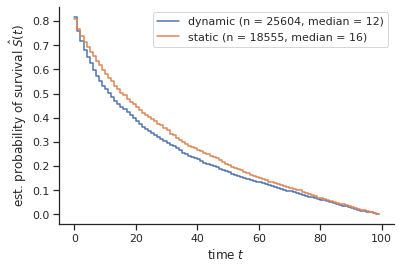

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44159.0,1.0,13.0,0.035616,-0.03,-0.03,-0.02


,count,median,min,max,std,mean
agg,,,,,,
static,18555,16.0,0,99,27.798132,26.144974
dynamic,25604,12.0,0,99,26.930155,23.178605


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44159.0 &                1.0 &                   13.0 &                0.035616 & -0.03 &                        -0.03 &                         -0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg     &        &         &      &      &            &            \\
\midrule
static  &  18555 &    16.0 &    0 &   99 &  27.798132 &  26.144974 \\
dynamic &  25604 &    12.0 &    0 &   99 &  26.930155 &  23.178605 \\
\bottomrule
\end{tabular}



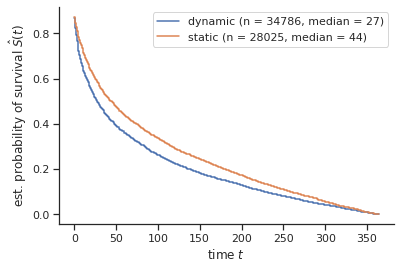

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,-0.06,-0.06,-0.05


,count,median,min,max,std,mean
agg,,,,,,
static,28025,44.0,0,364,100.783015,88.808314
dynamic,34786,27.0,0,364,93.202718,71.875151


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 & -0.06 &                        -0.06 &                         -0.05 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &       mean \\
agg     &        &         &      &      &             &            \\
\midrule
static  &  28025 &    44.0 &    0 &  364 &  100.783015 &  88.808314 \\
dynamic &  34786 &    27.0 &    0 &  364 &   93.202718 &  71.875151 \\
\bottomrule
\end{tabular}



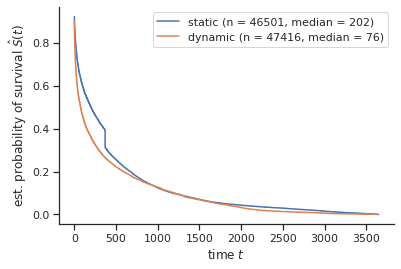

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,-0.07,-0.08,-0.07


,count,median,min,max,std,mean
agg,,,,,,
static,46501,202.0,0,3649,646.657801,435.953162
dynamic,47416,76.0,0,3634,594.099554,356.183461


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 & -0.07 &                        -0.08 &                         -0.07 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg     &        &         &      &       &             &             \\
\midrule
static  &  46501 &   202.0 &    0 &  3649 &  646.657801 &  435.953162 \\
dynamic &  47416 &    76.0 &    0 &  3634 &  594.099554 &  356.183461 \\
\bottomrule
\end{tabular}



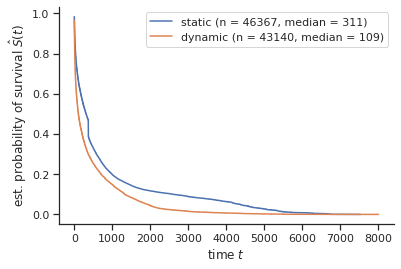

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,-0.1,-0.11,-0.1


,count,median,min,max,std,mean
agg,,,,,,
static,46367,311.0,1,7538,1327.401462,795.920223
dynamic,43140,109.0,1,8019,735.383140,433.889430


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &  Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 & -0.1 &                        -0.11 &                          -0.1 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg     &        &         &      &       &              &             \\
\midrule
static  &  46367 &   311.0 &    1 &  7538 &  1327.401462 &  795.920223 \\
dynamic &  43140 &   109.0 &    1 &  8019 &   735.383140 &  433.889430 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [80]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map(x):
    a = int(x['compilation_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'static', 2: 'dynamic', 0: 'other'}

compute_with_cutoff(df, f_map, condition_names, "most_used_language_compilation_class_survival_analysis")

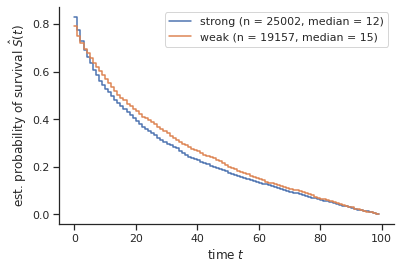

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44159.0,1.0,13.0,0.035616,0.01,0.01,0.02


,count,median,min,max,std,mean
agg,,,,,,
strong,25002,12.0,0,99,26.910909,23.492601
weak,19157,15.0,0,99,27.837418,25.641959


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44159.0 &                1.0 &                   13.0 &                0.035616 &  0.01 &                         0.01 &                          0.02 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg    &        &         &      &      &            &            \\
\midrule
strong &  25002 &    12.0 &    0 &   99 &  26.910909 &  23.492601 \\
weak   &  19157 &    15.0 &    0 &   99 &  27.837418 &  25.641959 \\
\bottomrule
\end{tabular}



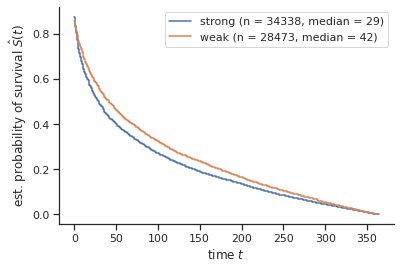

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,0.04,0.03,0.04


,count,median,min,max,std,mean
agg,,,,,,
strong,34338,29.0,0,364,94.449165,73.919797
weak,28473,42.0,0,364,99.636913,86.076072


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 &  0.04 &                         0.03 &                          0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg    &        &         &      &      &            &            \\
\midrule
strong &  34338 &    29.0 &    0 &  364 &  94.449165 &  73.919797 \\
weak   &  28473 &    42.0 &    0 &  364 &  99.636913 &  86.076072 \\
\bottomrule
\end{tabular}



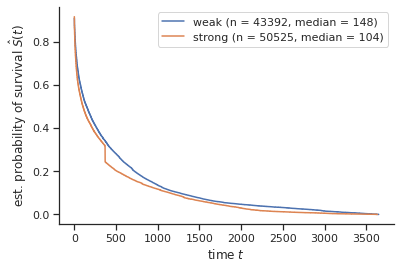

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,0.04,0.04,0.04


,count,median,min,max,std,mean
agg,,,,,,
strong,50525,104.0,0,3634,569.903557,357.527185
weak,43392,148.0,0,3649,674.838698,440.103982


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 &  0.04 &                         0.04 &                          0.04 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg    &        &         &      &       &             &             \\
\midrule
strong &  50525 &   104.0 &    0 &  3634 &  569.903557 &  357.527185 \\
weak   &  43392 &   148.0 &    0 &  3649 &  674.838698 &  440.103982 \\
\bottomrule
\end{tabular}



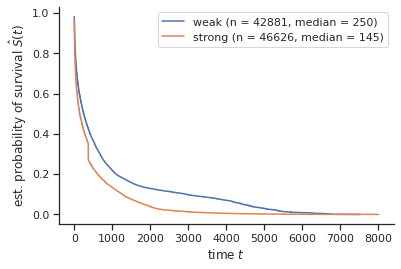

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,0.08,0.08,0.09


,count,median,min,max,std,mean
agg,,,,,,
strong,46626,145.0,1,8019,689.053057,421.124780
weak,42881,250.0,1,7538,1382.126802,839.230871


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 &  0.08 &                         0.08 &                          0.09 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg    &        &         &      &       &              &             \\
\midrule
strong &  46626 &   145.0 &    1 &  8019 &   689.053057 &  421.124780 \\
weak   &  42881 &   250.0 &    1 &  7538 &  1382.126802 &  839.230871 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [83]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


def f_map(x):
    a = int(x['type_class'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'strong', 2: 'weak', 0: 'other'}

compute_with_cutoff(df, f_map, condition_names, "most_used_language_type_class_survival_analysis")

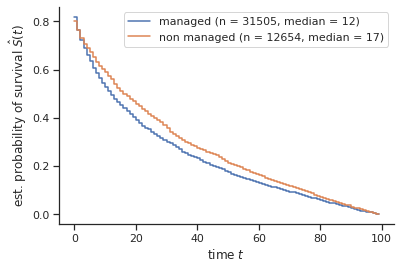

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,44159.0,1.0,13.0,0.035616,0.02,0.02,0.03


,count,median,min,max,std,mean
agg,,,,,,
managed,31505,12.0,0,99,26.851526,23.433201
non managed,12654,17.0,0,99,28.361121,26.894421


/tmp/ipykernel_3826835/48405254.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            44159.0 &                1.0 &                   13.0 &                0.035616 &  0.02 &                         0.02 &                          0.03 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &        std &       mean \\
agg         &        &         &      &      &            &            \\
\midrule
managed     &  31505 &    12.0 &    0 &   99 &  26.851526 &  23.433201 \\
non managed &  12654 &    17.0 &    0 &   99 &  28.361121 &  26.894421 \\
\bottomrule
\end{tabular}



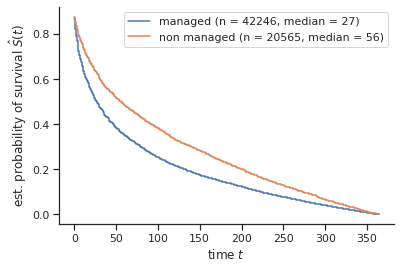

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,62811.0,1.0,34.0,0.093151,0.07,0.07,0.08


,count,median,min,max,std,mean
agg,,,,,,
managed,42246,27.0,0,364,91.651340,70.092648
non managed,20565,56.0,0,364,104.637962,98.612594


/tmp/ipykernel_3826835/48405254.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            62811.0 &                1.0 &                   34.0 &                0.093151 &  0.07 &                         0.07 &                          0.08 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &  max &         std &       mean \\
agg         &        &         &      &      &             &            \\
\midrule
managed     &  42246 &    27.0 &    0 &  364 &   91.651340 &  70.092648 \\
non managed &  20565 &    56.0 &    0 &  364 &  104.637962 &  98.612594 \\
\bottomrule
\end{tabular}



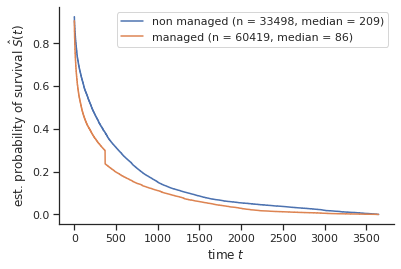

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,93917.0,1.0,122.0,0.334247,0.08,0.08,0.08


,count,median,min,max,std,mean
agg,,,,,,
managed,60419,86.0,0,3646,563.293419,341.459922
non managed,33498,209.0,0,3649,705.254455,493.473819


/tmp/ipykernel_3826835/48405254.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            93917.0 &                1.0 &                  122.0 &                0.334247 &  0.08 &                         0.08 &                          0.08 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &         std &        mean \\
agg         &        &         &      &       &             &             \\
\midrule
managed     &  60419 &    86.0 &    0 &  3646 &  563.293419 &  341.459922 \\
non managed &  33498 &   209.0 &    0 &  3649 &  705.254455 &  493.473819 \\
\bottomrule
\end{tabular}



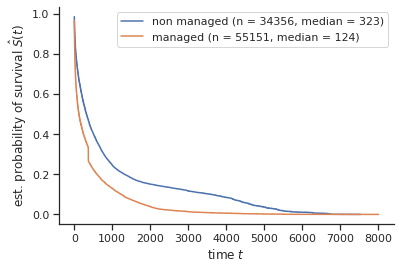

,Number of patiets,% z całej kohorty,"Survival days, median","Survival years, median",Dxy,Confidence interval 95% low,Confidence interval 95% high
0,89507.0,1.0,194.0,0.531507,0.12,0.12,0.12


,count,median,min,max,std,mean
agg,,,,,,
managed,55151,124.0,1,8019,694.613679,411.105728
non managed,34356,323.0,1,7538,1477.423533,959.061911


\begin{tabular}{lrrrrrrr}
\toprule
{} &  Number of patiets &  \% z całej kohorty &  Survival days, median &  Survival years, median &   Dxy &  Confidence interval 95\% low &  Confidence interval 95\% high \\
\midrule
0 &            89507.0 &                1.0 &                  194.0 &                0.531507 &  0.12 &                         0.12 &                          0.12 \\
\bottomrule
\end{tabular}
 \begin{tabular}{lrrrrrr}
\toprule
{} &  count &  median &  min &   max &          std &        mean \\
agg         &        &         &      &       &              &             \\
\midrule
managed     &  55151 &   124.0 &    1 &  8019 &   694.613679 &  411.105728 \\
non managed &  34356 &   323.0 &    1 &  7538 &  1477.423533 &  959.061911 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_3826835/48405254.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(S1.to_latex(), S2.to_latex())


<Figure size 432x288 with 0 Axes>

In [84]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

def f_map(x):
    a = int(x['memory_model'])
    if a ==1:
        return 1
    if a == 2:
        return 2
    else:
        return 0

condition_names = {1 : 'managed', 2: 'non managed', 0: 'other'}
compute_with_cutoff(df, f_map, condition_names, "most_used_language_memory_model_survival_analysis")